# 二元模型（Bigram）


## 数据集分析


In [1]:
words = open('prenoms.txt', 'r').read().splitlines()
print('Les 5 prénoms les plus populaires : ',words[:5])
print('Les 5 prénoms les moins populaires : ',words[-5:])
print('Le prénom le plus long : ',max(words, key=len))
print('Le prénom le plus court : ',min(words, key=len))


Les 5 prénoms les plus populaires :  ['MARIE', 'JEAN', 'PIERRE', 'MICHEL', 'ANDRÉ']
Les 5 prénoms les moins populaires :  ['ÉLOUEN', 'CHEYNA', 'BLONDIE', 'IMANN', 'GHILAIN']
Le prénom le plus long :  GUILLAUME-ALEXANDRE
Le prénom le plus court :  GUY


In [2]:
unique_characters = set()
for word in words:
  # Ajouter chaque caractère de la ligne à l'ensemble des caractères uniques
  for char in word.strip():
    unique_characters.add(char)
print('Nombre de caractères uniques : ',len(unique_characters))
print('Caractères uniques : ',unique_characters)

Nombre de caractères uniques :  45
Caractères uniques :  {'Ï', 'Ü', 'Ÿ', 'U', 'Ô', 'S', 'Æ', 'À', 'È', '-', 'W', 'H', 'Ê', 'É', 'R', 'M', 'E', 'Ë', 'N', 'Î', 'X', 'Ä', 'F', 'Â', 'K', 'D', 'Ö', 'I', 'J', 'Y', 'A', 'C', 'O', 'Û', 'Ù', 'B', 'Z', 'P', 'T', "'", 'Q', 'Ç', 'G', 'L', 'V'}


## 什么是二元模型？


回顾一下，本项目的目标是基于前面的字符预测下一个字符。在**二元模型**中，我们仅根据前一个字符来预测当前字符。这是此类模型中最简单的版本。


当然，要预测一个名字，我们需要从零开始。为了预测第一个字母，我们需要知道某个字母作为第一个字母的概率（最后一个字母同理）。因此，我们在构建二元模型之前，会在每个单词的开头和结尾添加一个特殊字符“.”。


在每个名字中，我们有多个二元模型的例子（每个例子都是独立的）。
我们以第一个名字为例，看看它包含多少个二元模型：


In [3]:
chs = ['.'] + list(words[0]) + ['.']
for ch1, ch2 in zip(chs, chs[1:]):
  bigram = (ch1, ch2)
  print(bigram)

('.', 'M')
('M', 'A')
('A', 'R')
('R', 'I')
('I', 'E')
('E', '.')


名字“Marie”包含6个二元模型。


## 计数方法


现在，我们构建一个 Python 字典，将数据集中所有二元模型的出现次数汇总起来。


In [4]:
b = {}
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1
sorted(b.items(), key = lambda kv: -kv[1])
print('Les 5 bigrammes les plus fréquents : ',sorted(b.items(), key = lambda kv: -kv[1])[:5])

Les 5 bigrammes les plus fréquents :  [(('A', '.'), 7537), (('E', '.'), 6840), (('A', 'N'), 6292), (('N', '.'), 3741), (('N', 'E'), 3741)]


现在，我们得到了整个数据集中二元模型的频率字典。可以看到，名字常以 A、E 或 N 结尾，且字母 A 和 N 经常连续出现，N 和 E 也是如此。


### 出现频次矩阵


以矩阵形式可视化和处理数据会更简便。我们将构建一个 46×46 的矩阵（45个字符 + 1个特殊字符“.”），其中行对应第一个字母，列对应第二个字母。


In [5]:
import torch
N = torch.zeros((46, 46), dtype=torch.int32)

我们将对字符进行排序，并使用 Python 字典创建查找表（look-up tables）。这样，我们可以将一个字符转换为整数（用于矩阵索引），反之亦然（从整数重构名字）。


In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

现在，我们将填充矩阵：


In [7]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

现在，我们可以显示这个矩阵（查找表）了。


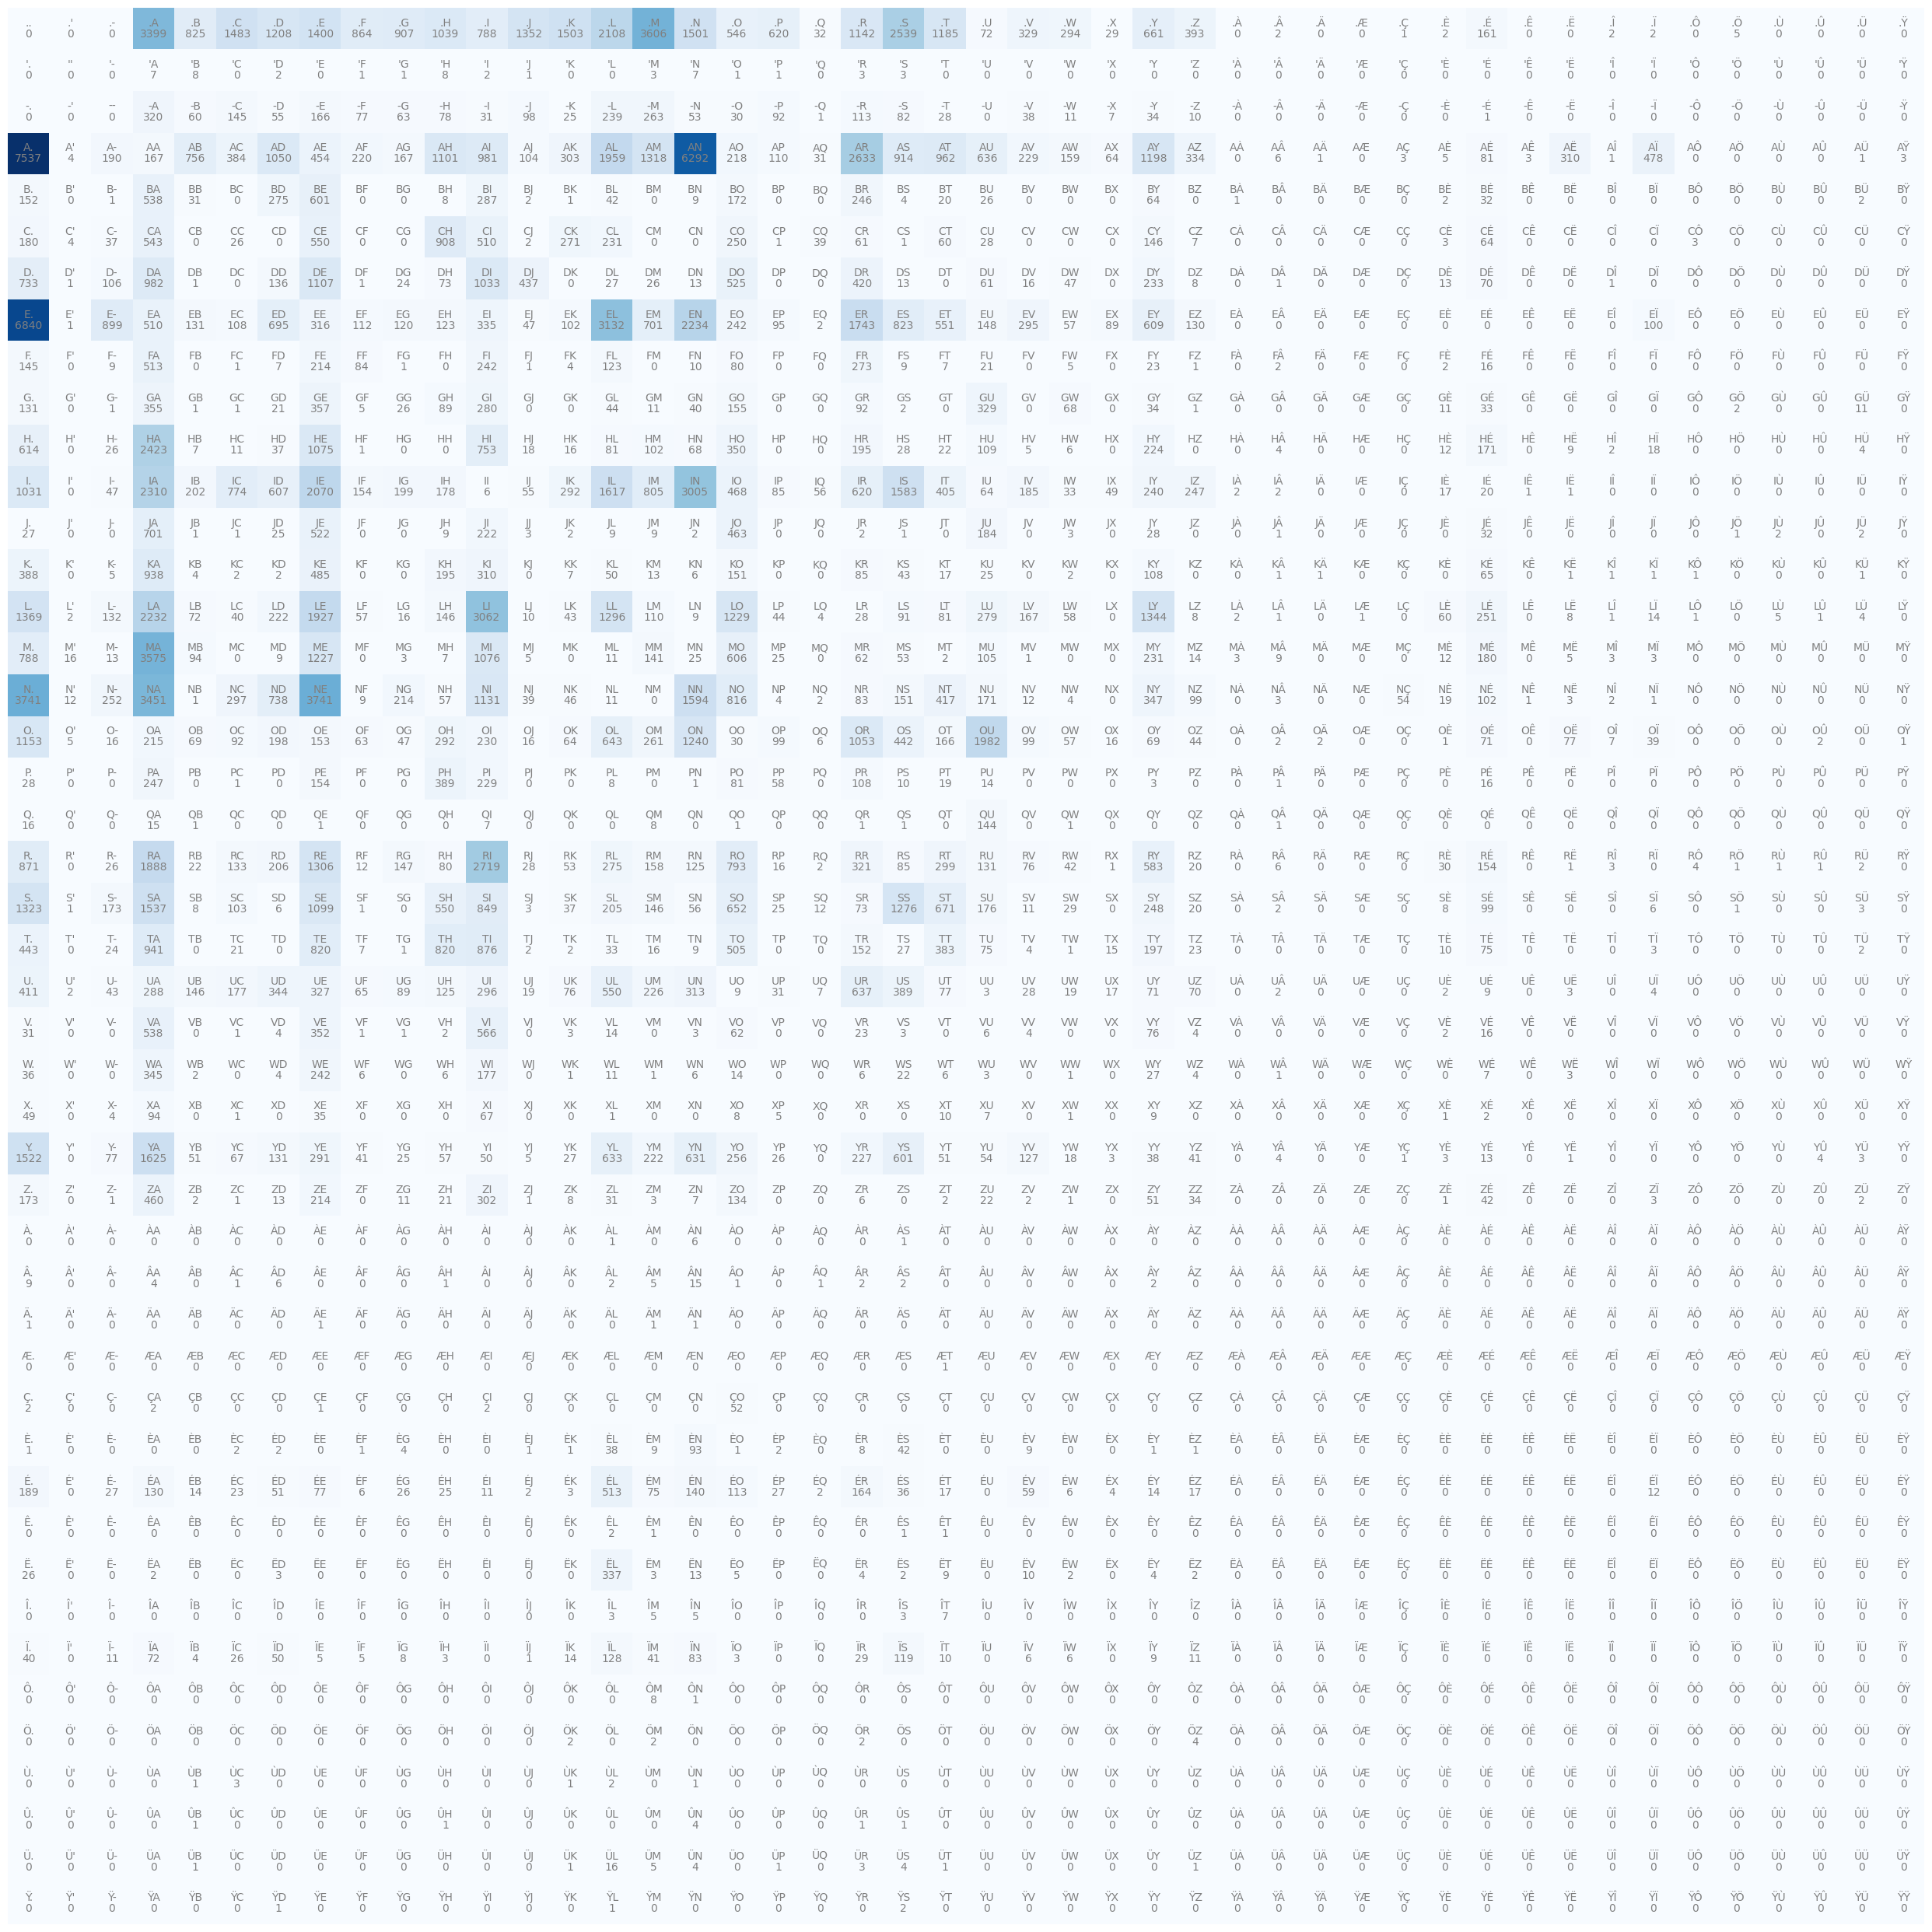

In [10]:
#Code pour dessiner une jolie matrice
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(32,32))
plt.imshow(N, cmap='Blues')
for i in range(46):
  for j in range(46):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

### 概率


要计算名字以某个字母开头的概率，我们需要查看特殊字符“.”所在的行（即第0行），并将该行的每个值除以该行所有值的总和（以得到0到1之间且总和为1的概率值）。


In [15]:
p = N[0].float()
p = p / p.sum()
print("Compte de la première ligne : ",N[0])
print("Probabilités : ",p)

Compte de la première ligne :  tensor([   0,    0,    0, 3399,  825, 1483, 1208, 1400,  864,  907, 1039,  788,
        1352, 1503, 2108, 3606, 1501,  546,  620,   32, 1142, 2539, 1185,   72,
         329,  294,   29,  661,  393,    0,    2,    0,    0,    1,    2,  161,
           0,    0,    2,    2,    0,    5,    0,    0,    0,    0],
       dtype=torch.int32)
Probabilités :  tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1330e-01, 2.7500e-02, 4.9433e-02,
        4.0267e-02, 4.6667e-02, 2.8800e-02, 3.0233e-02, 3.4633e-02, 2.6267e-02,
        4.5067e-02, 5.0100e-02, 7.0267e-02, 1.2020e-01, 5.0033e-02, 1.8200e-02,
        2.0667e-02, 1.0667e-03, 3.8067e-02, 8.4633e-02, 3.9500e-02, 2.4000e-03,
        1.0967e-02, 9.8000e-03, 9.6667e-04, 2.2033e-02, 1.3100e-02, 0.0000e+00,
        6.6667e-05, 0.0000e+00, 0.0000e+00, 3.3333e-05, 6.6667e-05, 5.3667e-03,
        0.0000e+00, 0.0000e+00, 6.6667e-05, 6.6667e-05, 0.0000e+00, 1.6667e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])


为了随机生成名字，我们不希望总是选择概率最高的字母（否则总会生成相同的名字）。我们希望根据概率选择字母。例如，如果字母“n”的概率为0.1，那么我们希望它有10%的概率被选中。
为此，我们使用 PyTorch 的 `torch.multinomial` 函数。


In [16]:
ix = torch.multinomial(p, num_samples=1, replacement=True).item()
itos[ix]

'Z'

每次调用时，我们会根据字母在测试数据集中的出现概率，得到不同的字母。


有了这些元素，我们现在可以从矩阵 N 生成名字了。理想情况下，我们可以直接创建一个包含概率的矩阵，以避免每次都要重新归一化。


In [17]:
# On copie N et on la convertit en float
P = N.float()
# On normalise chaque ligne
# On somme sur la première dimension (les colonnes)
print("Somme des lignes : ",P.sum(1, keepdims=True).shape)
P /= P.sum(1, keepdims=True) # /= est un raccourci pour P = P / P.sum(1, keepdims=True)
print("Matrice normalisée P est de taille : ",P.shape)
# On vérifie que la somme d'une ligne est égale à 1
print("Somme de la première ligne de P : ",P.sum(1)[0].item())

Somme des lignes :  torch.Size([46, 1])
Matrice normalisée P est de taille :  torch.Size([46, 46])
Somme de la première ligne de P :  1.0


**关于不同大小矩阵相除的说明**：您可能已经注意到，我们将一个 46×46 的矩阵除以一个 46×1 的矩阵，这看起来不可能。在 PyTorch 中，存在[广播规则](https://pytorch.org/docs/stable/notes/broadcasting.html)。我强烈建议您熟悉这一概念，因为它是常见错误的来源。要详细了解广播规则，您可以参考[奖励课程](../Bonus_CoursSpécifiques/04_Broadcasting.ipynb)。
在实践中，将 46×46 的矩阵除以 46×1 的矩阵时，PyTorch 会将 46×1 的矩阵“广播”为 46×46 的矩阵，通过复制 46 次基矩阵来实现。这样可以按预期执行运算。


### 生成


现在，我们终于可以用二元模型方法生成名字了！
我们将定义一个函数来生成名字：


In [18]:
def genName():
  out = []
  ix = 0 # On commence par '.'
  while True: # Tant qu'on n'a pas généré le caractère '.'
    p = P[ix] # On récupère la distribution de probabilité de la ligne correspondant au caractère actuel
    ix = torch.multinomial(p, num_samples=1, replacement=True).item() # On tire un échantillon
    out.append(itos[ix]) # On ajoute le caractère à notre prénom
    if ix == 0:
      break
  return ''.join(out)
genName()

'MARAUSUR.'

例如，我们可以生成10个随机名字：


In [19]:
for i in range(10):
  print(genName())

DA.
TYEYSE-SSCL.
DE.
ANINEDANDVI.
SOKE.
RENNA.
FUXA.
EROA.
FA.
KALEN.


可以看到，生成的名字质量不高...
为什么？因为二元模型是一种非常有限的方法。仅依赖上一个字符无法提供足够的信息来生成正确的名字。


## 模型评估


### 最大似然（Likelihood）


现在，我们想要在训练集上评估我们的模型。为此，我们使用最大似然法，类似于[第一课第二笔记本](../01_Fondations/02_RégressionLogistique.ipynb)中的方法。
最大似然（Likelihood）是一个度量值，对应于事件概率的乘积。为了获得一个好的模型，我们希望最大化似然值。


In [20]:
productOfProbs = 1
for w in words[:2]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    productOfProbs *= prob
    print(f"La probabilité de {ch1}->{ch2} est {prob.item():.3f}")
print("Le produit des probabilités est : ",productOfProbs.item())

La probabilité de .->M est 0.120
La probabilité de M->A est 0.431
La probabilité de A->R est 0.084
La probabilité de R->I est 0.256
La probabilité de I->E est 0.119
La probabilité de E->. est 0.321
La probabilité de .->J est 0.045
La probabilité de J->E est 0.232
La probabilité de E->A est 0.024
La probabilité de A->N est 0.201
La probabilité de N->. est 0.212
Le produit des probabilités est :  4.520583629652464e-10


我们很快发现，将概率相乘会带来问题。在这里，我们仅对数据集中30,000个元素中的2个进行相乘，就得到了一个非常小的值。如果对整个数据集进行相乘，结果将超出计算机的表示范围。


### 对数似然（Log-likelihood）


为了解决精度问题，我们使用对数，原因如下：

- 对数函数是单调的，即如果 $a > b$，则 $log(a) > log(b)$。在优化背景下，最大化对数似然等价于最大化似然。

- 对数的一个有用性质（解释了为什么它在优化和概率中常用）是：$log(a \times b) = log(a) + log(b)$。这使我们能够避免将小数相乘，从而超出计算机的精度范围。


因此，我们可以最大化对数似然，而不是似然。我们重新运行之前的循环，看看结果如何：


In [21]:
sumOfLogs = 0
for w in words[:2]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    sumOfLogs += torch.log(prob)
print("La somme des log est : ",sumOfLogs.item())

La somme des log est :  -21.517210006713867


这样我们得到了一个更合理的值。在优化问题中，我们通常更希望有一个需要最小化的函数。在完美模型的情况下，每个概率值为1，因此每个对数值为0，对数的总和也为0。否则，我们会得到负值，因为概率总是小于1，且 $log(a) < 0 \text{ 如果 } a < 1$。
为了得到一个最小化问题，我们使用负对数似然，它仅仅是对数似然的相反数。


通常，我们使用平均值而不是总和，因为平均值更易读且在优化方面与总和等价。我们将在整个数据集的名字上计算它。


In [22]:
sumOfLogs = 0
n=0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    sumOfLogs += - torch.log(prob)
    n+=1
print("La somme des negative log est : ",sumOfLogs.item())
print("La moyenne des negative log est : ",sumOfLogs.item()/n)

La somme des negative log est :  564925.125
La moyenne des negative log est :  2.4960792002651053


数据集的负对数似然值为2.49。

您还可以查看自己的名字相对于数据集的平均值是否常见。只需将我的名字“SIMON”替换为您的名字（大写）即可。


In [23]:
sumOfLogs = 0
n=0
for w in "SIMON":
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    sumOfLogs += - torch.log(prob)
    n+=1
print("La moyenne des negative log est : ",sumOfLogs.item()/n)

La moyenne des negative log est :  2.598056602478027


如果您的名字对应的负对数似然值小于数据集的值，那么您的名字比较常见。否则，它可能不太常见。


## 神经网络方法


### 计数方法的问题


现在，我们将尝试用不同的方法解决同一个问题。我们之前通过简单计数二元模型的出现次数并计算概率来解决问题。这种方法适用于二元模型，但对于更复杂的 N-gram 则不适用。


实际上，我们的查找表对于两个字符来说是 46×46 大小。如果考虑 N 个字符（即用 N-1 个字符预测第 N 个字符），那么可能性会大大增加。可以简单计算，该表的大小为 $46^N$。对于 N=4，这将产生一个大小为 4,477,456 的表。对于大型上下文（如今的模型有数万个 token 的上下文，且每次有超过46种可能性），这种方法完全行不通。


因此，神经网络方法非常有吸引力。在接下来的课程中，我们将展示如何用神经网络解决这个问题，这将帮助您理解随着上下文增加，网络的能力。


### 神经网络的数据集


我们的神经网络将接收一个字符作为输入，并预测下一个字符。我们可以使用负对数似然函数作为损失函数，以尽可能接近计数方法得到的二元模型值。


首先，我们创建训练数据集。我们重用之前遍历二元模型的循环，这次我们索引两个列表：`xs` 用于输入，`ys` 用于标签。


In [18]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. M
M A
A R
R I
I E
E .


In [19]:
print("valeurs d'entrée : ",xs)
print("valeurs de sortie : ",ys)

valeurs d'entrée :  tensor([ 0, 15,  3, 20, 11,  7])
valeurs de sortie :  tensor([15,  3, 20, 11,  7,  0])


对于输入值0（对应“.”），我们想要预测标签15（对应“M”）。


这些列表的问题是它们包含整数，而神经网络的输入不能是整数。在自然语言处理领域，我们通常使用**独热编码（one-hot encoding）**，它将一个索引转换为一个全零向量，仅在索引位置上为1。向量的大小对应于可能的类别数量，这里是46。


In [20]:
import torch.nn.functional as F
# one-hot encoding
xenc = F.one_hot(xs, num_classes=46).float() # conversion en float pour le NN
print("Encodage one-hot des deux premiers caractères: ",xenc[:2])

Encodage one-hot des deux premiers caractères:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


可以看到，第一个向量的第0位是1，第二个向量的第15位是1。这些向量将作为我们神经网络的输入。我们可以可视化这些向量，以更好地理解独热编码的作用。


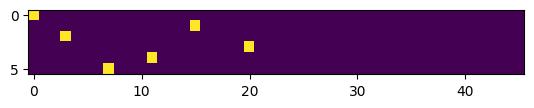

In [21]:
# Les 5 premiers vecteurs one-hot
plt.imshow(xenc)

### 我们的神经网络


现在，我们将创建我们的神经网络。它将是一个极其简单的神经网络，只包含一层。对于层的大小，我们输入一个大小为 $n \times 46$ 的向量，因此第一个维度的大小为46。在输出端，我们希望得到所有字符的概率分布。因此，我们的网络层大小为 $46 \times 46$。


首先，我们用随机值初始化我们的层：


In [22]:
# On met le paramètre requires_grad à True pour pouvoir optimiser la matrice par descente de gradient
W = torch.randn((46, 46), requires_grad=True) 

我们神经网络的前向传播仅包括输入与层之间的矩阵乘法。然后，我们将应用 *softmax* 函数（见 CNN 课程）以获得概率分布。


In [23]:
# One hot encoding sur les entrées
xenc = F.one_hot(xs, num_classes=46).float() 
# Multiplication matricielle (forward pass)
logits = xenc @ W  # @ est la multiplication matricielle
#Softmax pour obtenir des probabilités
counts = logits.exp() 
probs = counts / counts.sum(1, keepdims=True) 
print(probs.shape)


torch.Size([6, 46])


我们得到了6个字符的概率分布。我们将可视化未经训练的神经网络的输出，并计算负对数似然，以了解我们与计数方法得到的模型之间的差距。


In [24]:
nlls = torch.zeros(6)
for i in range(6):
  x = xs[i].item() # index de l'entrée
  y = ys[i].item() # index du label
  print('--------')
  print(f'bigramme actuel {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('entrée du réseau de neurones :', x)
  print('sortie du réseau (probabilité) :', probs[i])
  print('vrai label :', y)
  p = probs[i, y]
  print('probabilité donné par le réseau sur le caractère réel :', p.item())
  logp = torch.log(p)
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('negative log likelihood moyen, i.e. loss =', nlls.mean().item())

--------
bigramme actuel 1: .M (indexes 0,15)
entrée du réseau de neurones : 0
sortie du réseau (probabilité) : tensor([0.0146, 0.0210, 0.0823, 0.0077, 0.0160, 0.0483, 0.0943, 0.0204, 0.0079,
        0.0112, 0.0085, 0.0179, 0.0188, 0.0292, 0.0022, 0.0092, 0.0200, 0.0094,
        0.0097, 0.0191, 0.1091, 0.0122, 0.0092, 0.0287, 0.0120, 0.0088, 0.0053,
        0.0217, 0.0177, 0.0050, 0.0038, 0.0483, 0.0320, 0.0441, 0.0105, 0.0126,
        0.0266, 0.0092, 0.0262, 0.0081, 0.0430, 0.0012, 0.0102, 0.0025, 0.0126,
        0.0116], grad_fn=<SelectBackward0>)
vrai label : 15
probabilité donné par le réseau sur le caractère réel : 0.009214116260409355
negative log likelihood: 4.687018394470215
--------
bigramme actuel 2: MA (indexes 15,3)
entrée du réseau de neurones : 15
sortie du réseau (probabilité) : tensor([0.0574, 0.1353, 0.0227, 0.0032, 0.1142, 0.0148, 0.1007, 0.0162, 0.0242,
        0.0089, 0.0040, 0.0459, 0.0023, 0.0081, 0.0064, 0.0124, 0.0083, 0.0112,
        0.0172, 0.0062, 0.0033, 0.0

在计算损失时，我们将按如下方式计算网络输出相对于标签的负对数似然：


In [25]:
# Calcul de la loss
loss = -probs[torch.arange(6), ys].log().mean()
print(loss.item())
# On remet les gradients à zéro (None est plus efficace)
W.grad = None 
# Calcul des gradients automatique de pytorch
loss.backward()
print(W.grad)

4.670102596282959
tensor([[0.0024, 0.0035, 0.0137,  ..., 0.0004, 0.0021, 0.0019],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


可以看到，我们计算了矩阵 W 相对于损失的梯度。与之前的课程一样，我们可以用一个步长（学习率 *learning_rate*）沿梯度方向更新模型的权重。


In [26]:
# avec un learning_rate de 0.1
W.data += -0.1 * W.grad

### 优化


基于之前的所有内容，我们现在可以将各部分组合起来并优化我们的模型。


**创建完整数据集**
首先，我们将通过重用之前的循环（但遍历所有名字）来创建完整的数据集。


In [27]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)


number of examples:  226325


**初始化模型**
现在，我们可以像之前一样初始化模型，并选择学习率 *learning_rate* 和迭代次数。


In [28]:
W = torch.randn((46, 46), requires_grad=True)
lr=50 # en pratique, dans ce petit problème, un learning rate de 50 fonctionne bien ce qui peut sembler étonnant
iterations=100

**梯度下降**
现在，我们将在模型上应用梯度下降算法。


In [29]:
# Descente du gradient
for k in range(iterations):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=46).float() # transformation one hot sur les entrées
  logits = xenc @ W
  probs=F.softmax(logits,dim=1) # On applique le softmax
  loss = -probs[torch.arange(num), ys].log().mean() # Calcul du negative log likelihood (loss)
  if k%10==0:
    print('loss iteration '+str(k)+' : ',loss.item())
  
  # retropropagation
  W.grad = None # Remettre la gradient à zéro à chaque itération (à ne pas oublier !!!!)
  loss.backward()
  
  # Mise à jour des poids
  W.data += -50 * W.grad

loss iteration 0 :  4.346113204956055
loss iteration 10 :  2.94492769241333
loss iteration 20 :  2.7590363025665283
loss iteration 30 :  2.6798315048217773
loss iteration 40 :  2.637108087539673
loss iteration 50 :  2.610524892807007
loss iteration 60 :  2.5923469066619873
loss iteration 70 :  2.5791807174682617
loss iteration 80 :  2.569261074066162
loss iteration 90 :  2.561541795730591


经过100次迭代后，我们得到了一个接近计数方法模型的负对数似然值。这实际上是二元模型在训练数据上的最大能力。


**用我们的模型生成名字**
现在，我们可以用我们的模型生成名字了。


In [30]:
for i in range(5):
  
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=46).float()
    logits = xenc @ W 
    # Prédiction des probabilités de la lettre suivante
    p=F.softmax(logits,dim=1)
    
    # On fait un tirage aléatoire de la prochaine lettre en suivante la distribution p 
    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    # Conversion en lettre
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

JE.
S.
ADJULA.
M.
LVERTYÜCI.


### 补充说明


权重矩阵 $W$ 的大小与计数方法中使用的矩阵 $N$ 相同。我们通过神经网络方法所实现的，实际上是学习矩阵 $N$。
我们可以通过观察 `xenc @ W` 操作来验证这一直觉。这是一个 $1 \times 46$ 的行矩阵与一个 $46 \times 46$ 的方阵的矩阵乘法。此外，行矩阵中除了字母索引 $i$ 处为1外，其余均为零。该矩阵乘法的结果是矩阵 $W$ 的第 $i$ 行。
这与我们在计数方法中所做的完全一致，即从矩阵 $P$ 的第 $i$ 行中获取概率值。
